#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


## Сервисный раздел

In [312]:
# Необходимо установить !
#

#!pip install lightgbm

In [313]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from scipy.stats import shapiro

In [314]:
from sklearn.linear_model import RidgeCV, Ridge, LassoCV, Lasso

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import make_scorer, mean_squared_error

from lightgbm import LGBMRegressor
import time



In [315]:
def append_result(model, dataset, time_fit, time_predict, RMSE_train, RMSE_test):
    '''
    Функция добавляет результаты работы модели в итоговую таблицу результатов 
    '''
    return df_result.append({'Model':model, 'DataSet':dataset,\
                     'Time Fit, (сек)':'%.2f'%time_fit,'Time Predict, (сек)':'%.2f'%time_fit,\
                     'RMSE train':'%.2f'%RMSE_train, 'RMSE test':'%.2f'%RMSE_test, },
                     ignore_index = True)
    
    


In [316]:
def modify_categorical_OneHotEncoding(df, categorical_columns):
    '''
    Преобразует переданный список полей датасета методом One Hot Encoding
    '''
    df_encoded = pd.get_dummies(df, columns = categorical_columns , prefix_sep = "_", drop_first = True, sparse = False)
    
    return df_encoded

In [317]:
def RMSE(y_valid, y_pred):
    '''
    Пользовательский скорер RMSE
    '''
    return  mean_squared_error(y_valid, y_pred) **.5 

RMSE_scorer = make_scorer(RMSE, greater_is_better = False)

## Подготовка

In [318]:
state = 12345
cores = -1
df_result = pd.DataFrame()

In [319]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates = [0], index_col = [0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Исходные данные - количество заказов каждые 10 минут

In [320]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Выполним перегруппировку данных до 1 часа.

In [321]:
df_h = df.resample('1H').sum()
df_h.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [322]:
df_h.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

###  Первичная визуализация и  распределение

Визуализируем данные


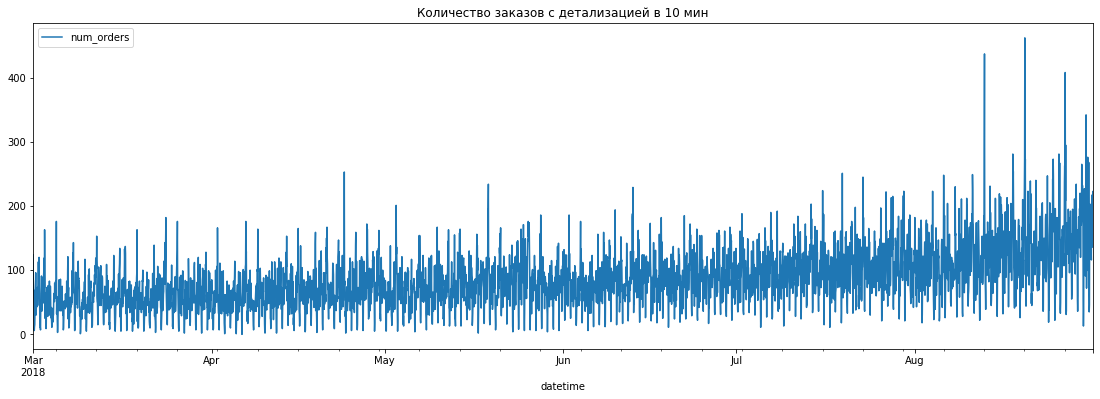

In [323]:
df_h.plot(figsize = (19,6), style = '-', title = 'Количество заказов с детализацией в 10 мин');


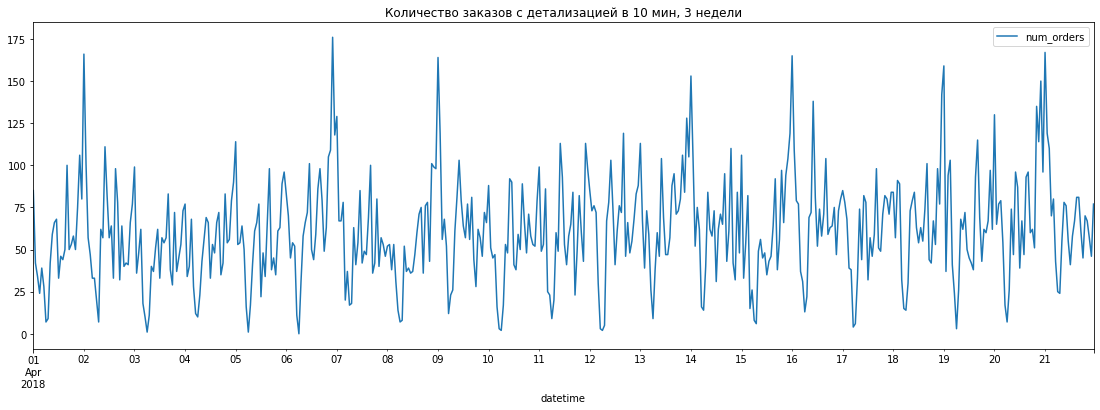

In [324]:
df_h['2018-04-01':'2018-04-21'].plot(figsize = (19,6), style = '-', title = 'Количество заказов с детализацией в 10 мин, 3 недели');

Очевидно имеются периодические составлящие, вероятно на уровне недели и одного дня. 

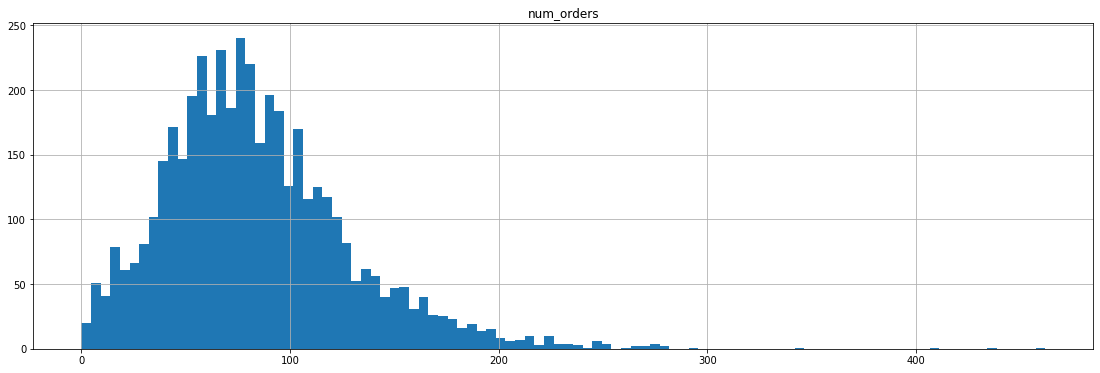

In [325]:
df_h.hist(figsize = (19,6), bins = 100, grid = True);

Распределение похоже на  нормальное. Проверим

In [326]:
stat, p = shapiro(df_h['num_orders'])
print('Statistics=%.5f, p=%.5f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Можем принять гипотезу о нормальности')
else:
    print('Вынуждены отклонить гипотезу о нормальности')

Statistics=0.94202, p=0.00000
Вынуждены отклонить гипотезу о нормальности


In [327]:
df_h.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


###  Стационарность

Визиульно видно что мы имеем дело как бы с не стационарным рядом, есть восходящий тренд, а также переменная дисперсия. Проверим строго, на основании теста Дики - Фуллера


In [328]:
test = adfuller(df_h['num_orders'])

In [329]:
print ('adf: ', test[0]) 
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -3.068924289027949
p-value:  0.02894005140261345
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
единичных корней нет, ряд стационарен


Ряд условно стационарен. Это очень хорошо, не потребуется больших преобразований, сразу пойдем изучать закономерности и нарезать фичи.

###  Тренд

Выделим в исходных данных составляющие.


In [330]:
decomposed = seasonal_decompose(df_h) 

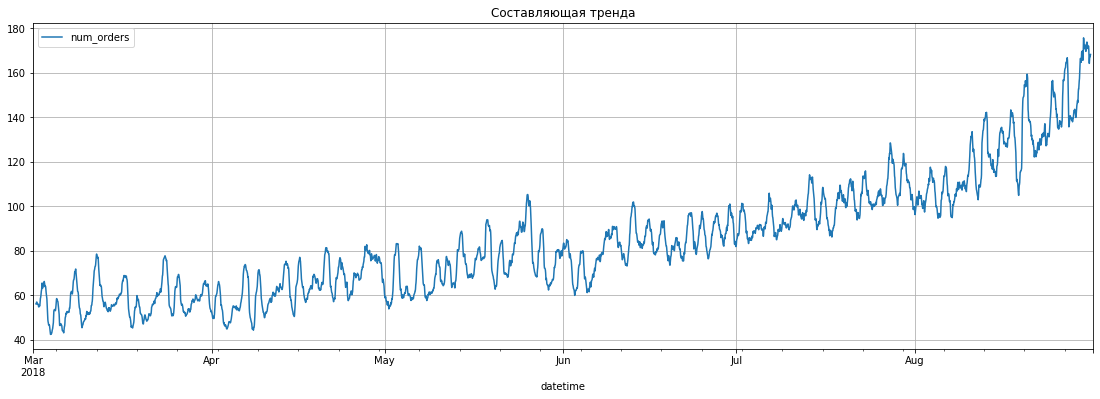

In [331]:
decomposed.trend.plot(figsize = (19,6), grid = True, title = 'Составляющая тренда');

Так или иначе восходящий тренд имеется, для учета моделью этого факта потребуется фича отвечающая за тренд. Предположительно это будет скользящая средняя с широким окном усреднения.

In [332]:
# Например это будет 1 неделя. 7 * 24 = 168
decomposed.trend['MA168'] = decomposed.trend['num_orders'].rolling(168).mean()

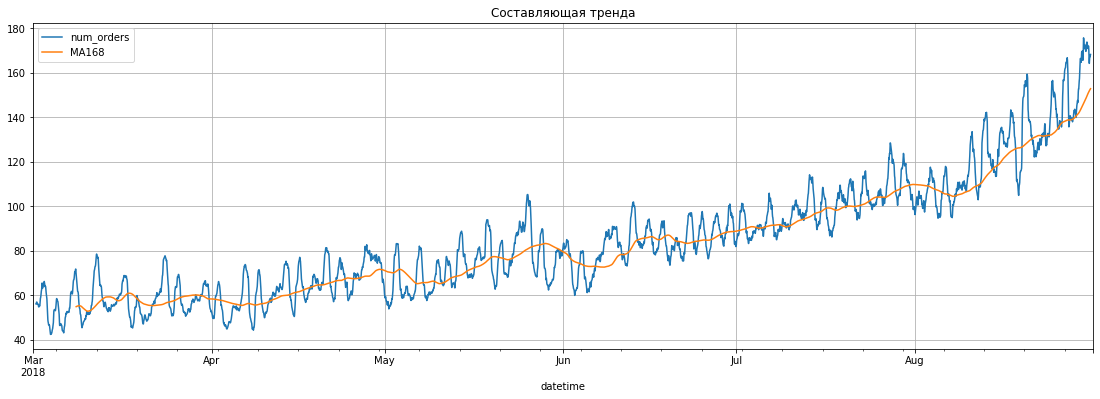

In [333]:
decomposed.trend.plot(figsize = (19,6), grid = True, title = 'Составляющая тренда');

###  Сезонность и периодичность

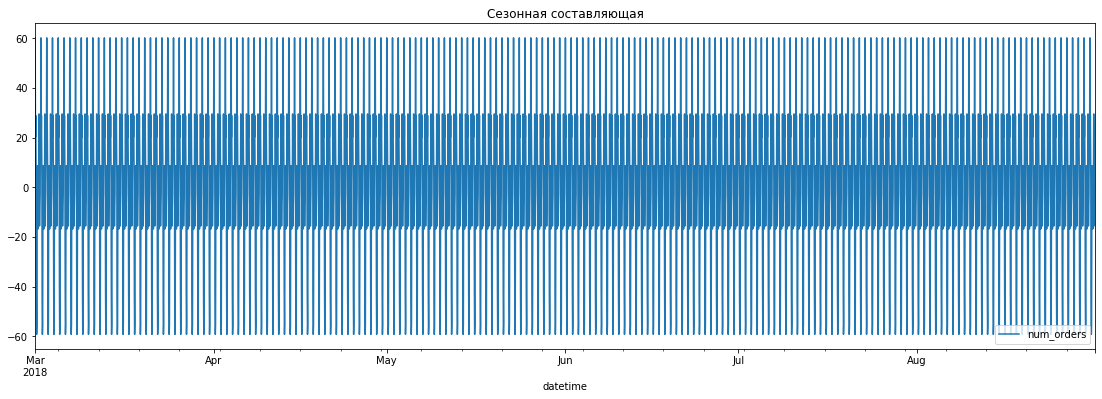

In [334]:
decomposed.seasonal.plot(figsize = (19,6), title = 'Сезонная составляющая');

Сезонная составляющая тоже есть. Уточнимся

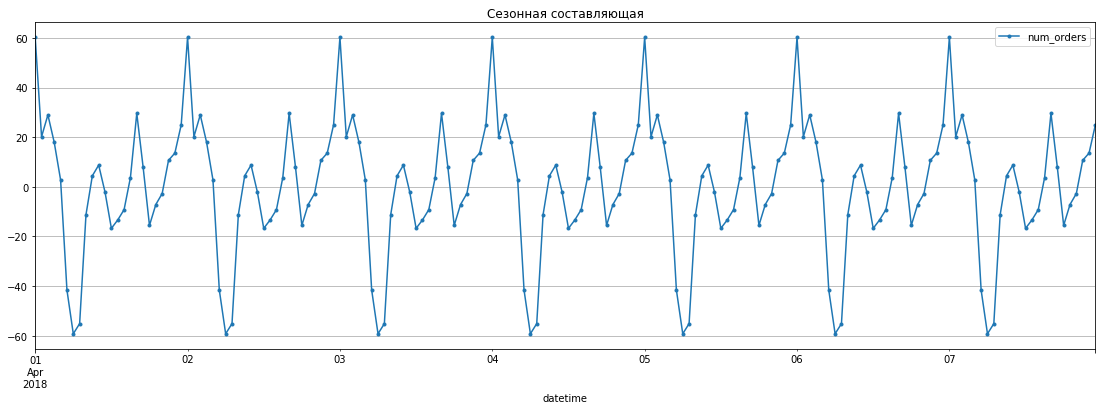

In [335]:
decomposed.seasonal['2018-04-01':'2018-04-07'].plot(figsize = (19,6), style = '.-', grid = True, title = 'Сезонная составляющая');

Налицо циклическая составляющая внутри дня. Потому фича - час напрашивается сама собой.

Посмотрим цикличность внутри месяца. Сделаем дополнительный ресемпл до 1 дня.

In [336]:
df_d = df.resample('1D').sum()
df_d.head()

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290
2018-03-04,1141
2018-03-05,1259


In [337]:
decomposed_d = seasonal_decompose(df_d) 

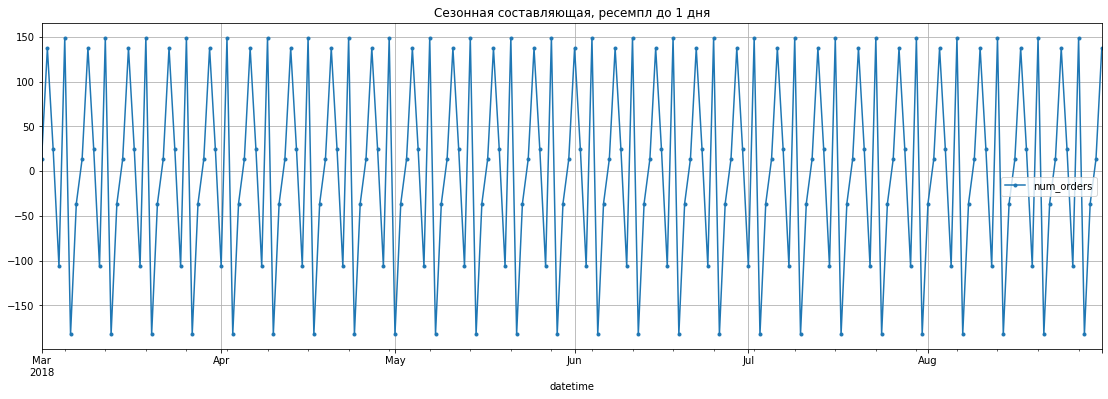

In [338]:
decomposed_d.seasonal.plot(figsize = (19,6), style = '.-', grid = True, title = 'Сезонная составляющая, ресемпл до 1 дня');

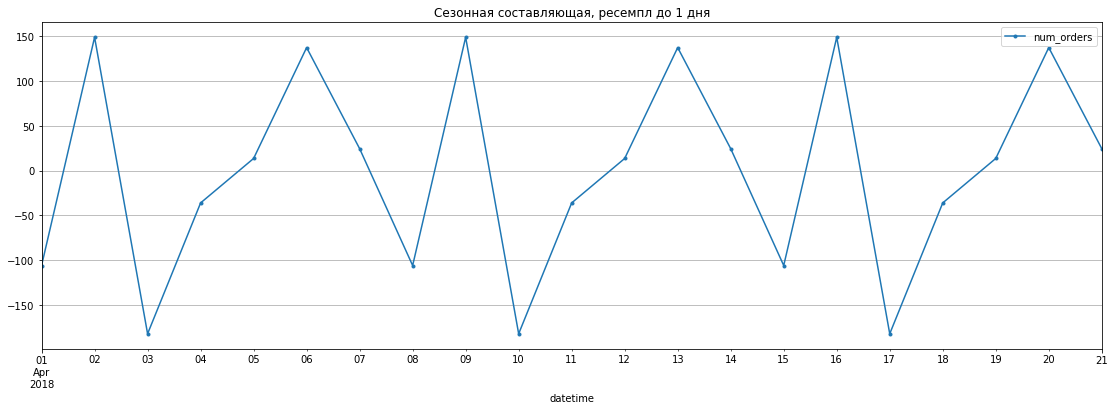

In [339]:
decomposed_d.seasonal['2018-04-01':'2018-04-21'].plot(figsize = (19,6), style = '.-', grid = True, title = 'Сезонная составляющая, ресемпл до 1 дня');

1 апреля - воскресенье. 2,9,16 апреля понедельники - пик, далее вторник резкое снижение и плавный рост к пятнице. Очевидно для учета этого факта потребуется фича - номер дня недели.

###  Возможно что то еще

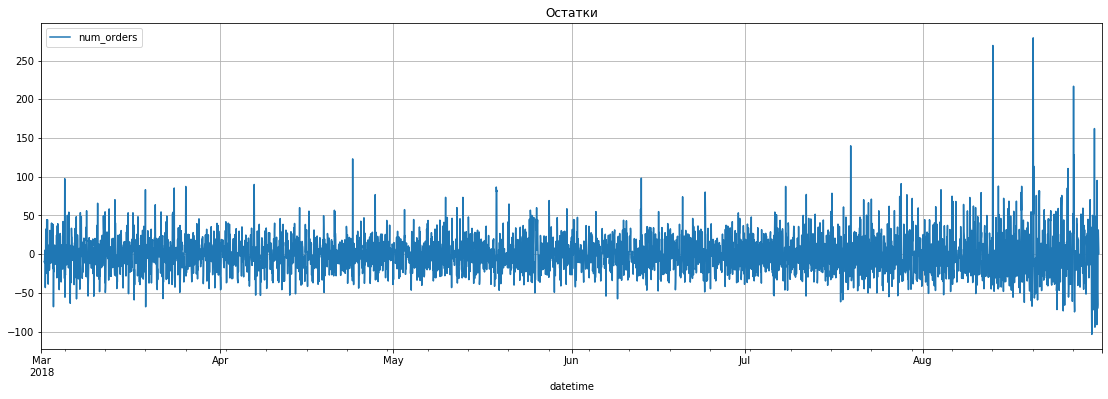

In [340]:
decomposed.resid.plot(figsize = (19,6), grid = True, title = 'Остатки');

Кроме тренда и сезонности в данных еще достаточно много "знаний", сначала попробуем без каких то дополнительных фич, затем нагенерим какое то количество "лаг".
Если метрики будут не достаточные, то повторим все тоже самое, предварительно обработав ряд с целью минимизации тренда и изменения дисперсии.

## Обучение

### Подготовка данных

In [341]:
## Исходные данные сгруппированные до часа
df_h = df.resample('1H').sum()

## Фичи для учета тренда
#df_h['MA168'] = df_h['num_orders'].rolling(168).mean()    # Сначала хотел протащить среднюю, но ее же в тестовых даных не будет
df_h['week_of_year'] = df_h.index.weekofyear

## Фичи для учета сезонности
df_h['dayofweek'] = df_h.index.dayofweek
df_h['hour'] = df_h.index.hour

## Лаги
for i in range(1, 25):
        df_h["lag_{}".format(i)] = df_h.num_orders.shift(i)


## После подсчета средней в начале датасета появились NaN, удалим
df_h.dropna(inplace = True)

In [342]:
df_h.head()

,num_orders,week_of_year,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,9,4,0,58.0,113.0,66.0,61.0,45.0,73.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-02 01:00:00,120,9,4,1,90.0,58.0,113.0,66.0,61.0,45.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-02 02:00:00,75,9,4,2,120.0,90.0,58.0,113.0,66.0,61.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-02 03:00:00,64,9,4,3,75.0,120.0,90.0,58.0,113.0,66.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-02 04:00:00,20,9,4,4,64.0,75.0,120.0,90.0,58.0,113.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0


In [343]:
categorical_columns = ['dayofweek', 'hour']

df_h = modify_categorical_OneHotEncoding(df_h, categorical_columns)
df_h.head()


,num_orders,week_of_year,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,9,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,...,0,0,0,0,0,0,0,0,0,0
2018-03-02 01:00:00,120,9,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,0,0,0,0,0,0,0,0,0,0
2018-03-02 02:00:00,75,9,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,0,0,0,0,0,0,0,0,0,0
2018-03-02 03:00:00,64,9,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,0,0,0,0,0,0,0,0,0,0
2018-03-02 04:00:00,20,9,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,0,0,0,0,0,0,0,0,0,0


In [344]:
df_h.describe()

,num_orders,week_of_year,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
count,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,...,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000
mean,84.573543,22.142077,84.540073,84.515027,84.493852,84.472678,84.451958,84.421448,84.382058,84.346995,...,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667
std,45.050123,7.556955,45.015225,44.968748,44.955561,44.944716,44.941932,44.904187,44.863722,44.835856,...,0.199849,0.199849,0.199849,0.199849,0.199849,0.199849,0.199849,0.199849,0.199849,0.199849
min,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,54.000000,16.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,78.000000,22.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,108.000000,29.000000,108.000000,108.000000,107.250000,107.000000,107.000000,107.000000,107.000000,107.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,462.000000,35.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Стандартное отклонение 45, запомним эту цифру

In [345]:
df_X = df_h.drop('num_orders', axis = 1)

X = df_X.values
y = df_h['num_orders'].values

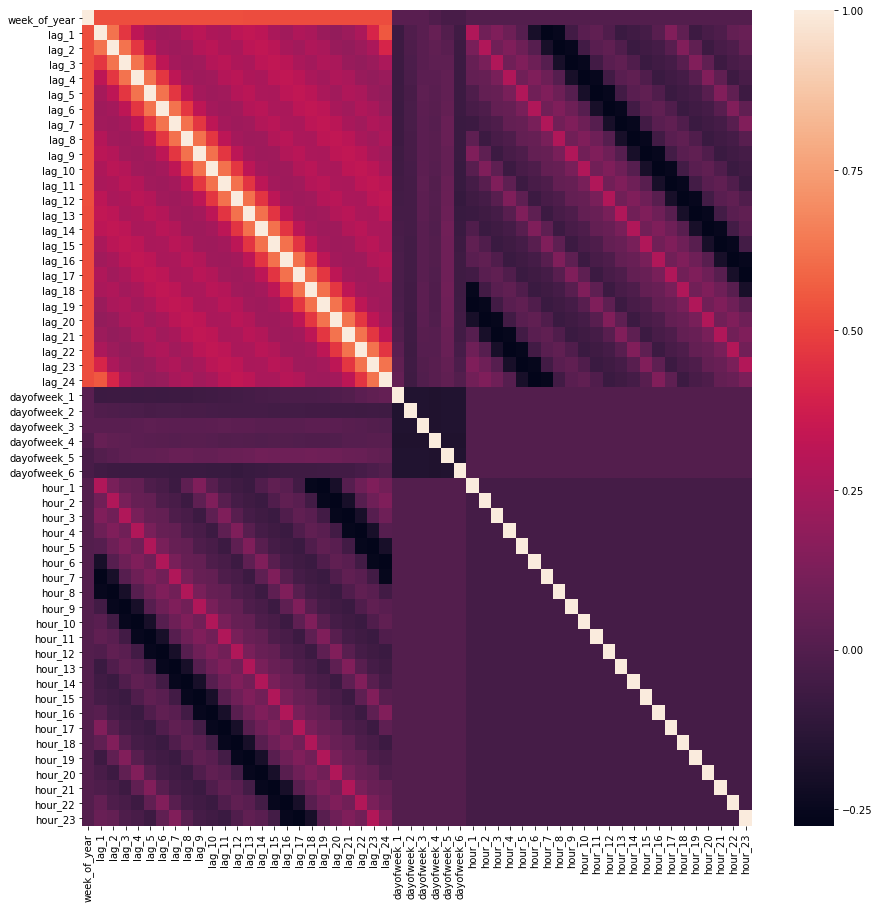

In [346]:
plt.figure(figsize = (15,15))
sns.heatmap(df_X.corr());

Интересная картинка с корреляцией. Все лаги имеют повышенную корреляцию, что как бы логично. Возможно имеет смысл лаги сделать с более длинным сдвигом. 

Отработка данных начнется с регрессии с регуляризацией, масшабирование обязательно.

In [347]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [348]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = .1, random_state = state, shuffle = False)

In [349]:
X_scaled.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4392, 54), (4392,), (3952, 54), (440, 54), (3952,), (440,))

### RidgeCV

In [350]:
# Специальная кроссвалицация для временных рядов.

cv = TimeSeriesSplit(n_splits = 5)

Для наглядности приведу картинку из инета с 4 фолдами, но смысл понятен.

<a href="https://imgbb.com/"><img src="https://i.ibb.co/k5QWwYL/crossval-time.jpg" alt="crossval-time" border="0"></a>

In [351]:
#model = LassoCV( cv = cv, alphas = np.linspace(0.01, 1000, 10))
model = RidgeCV(scoring=RMSE_scorer, cv = cv, alphas = np.linspace(0.01, 1000, 10))

In [352]:
model.get_params()

{'alphas': array([1.0000e-02, 1.1112e+02, 2.2223e+02, 3.3334e+02, 4.4445e+02,
        5.5556e+02, 6.6667e+02, 7.7778e+02, 8.8889e+02, 1.0000e+03]),
 'cv': TimeSeriesSplit(max_train_size=None, n_splits=5),
 'fit_intercept': True,
 'gcv_mode': None,
 'normalize': False,
 'scoring': make_scorer(RMSE, greater_is_better=False),
 'store_cv_values': False}

In [353]:
start_time = time.time()
model.fit(X_train, y_train)
time_fit = time.time() - start_time
print('Время обучения RidgeCV: %.3f сек.'%time_fit)

Время обучения RidgeCV: 7.056 сек.


In [354]:
print('Коэффицент регуляризации: %.3f '%model.alpha_, )

Коэффицент регуляризации: 0.010 


In [355]:
pd.DataFrame(model.coef_, df_X.columns,\
                   columns = ['Коэффициенты']).sort_values(by = 'Коэффициенты', ascending = False)

,Коэффициенты
week_of_year,10.055319
lag_1,6.721403
lag_24,5.962896
lag_2,4.429902
lag_7,3.786302
lag_12,2.697887
lag_3,2.565304
lag_11,2.560996
lag_8,1.838474
lag_13,1.742854


Очень логично регрессия разложила коэффициенты. Во главе угла главный тренд, дальше серия лаг, ну и номер дня конечно.

In [356]:
start_time = time.time()
predict_train = model.predict(X_train)
time_predict = time.time() - start_time
print('Время предсказания RidgeCV: %.3f сек.'%time_predict)

Время предсказания RidgeCV: 0.072 сек.


In [357]:
RMSE_train = mean_squared_error(y_train, predict_train)**.5
print('Метрика RMSE на тренировочных данных данных: %.2f'%RMSE_train)

Метрика RMSE на тренировочных данных данных: 22.69


На тренировочных данных угадываем до уровня половины стандартного отклонения

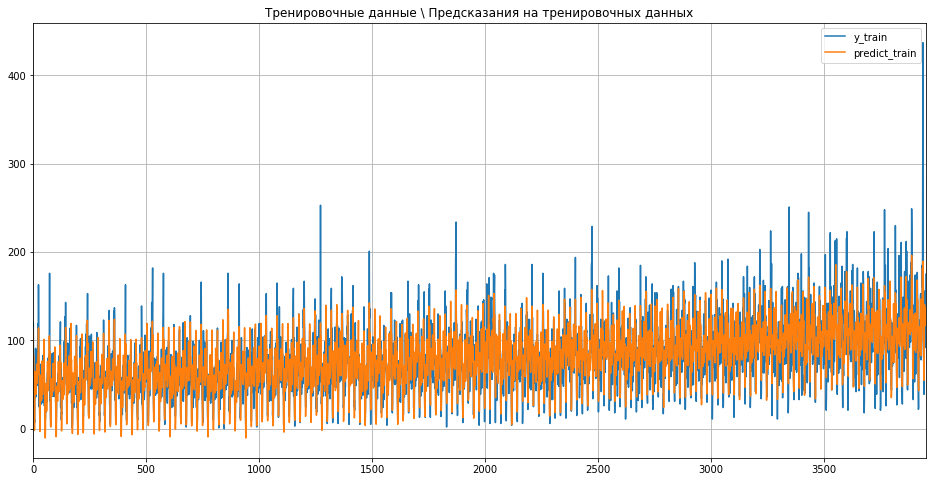

In [358]:
df_predict = pd.DataFrame({'y_train':y_train, 'predict_train':predict_train})
df_predict.plot(figsize = (16,8), style = '-', grid = True, title = 'Тренировочные данные \ Предсказания на тренировочных данных');

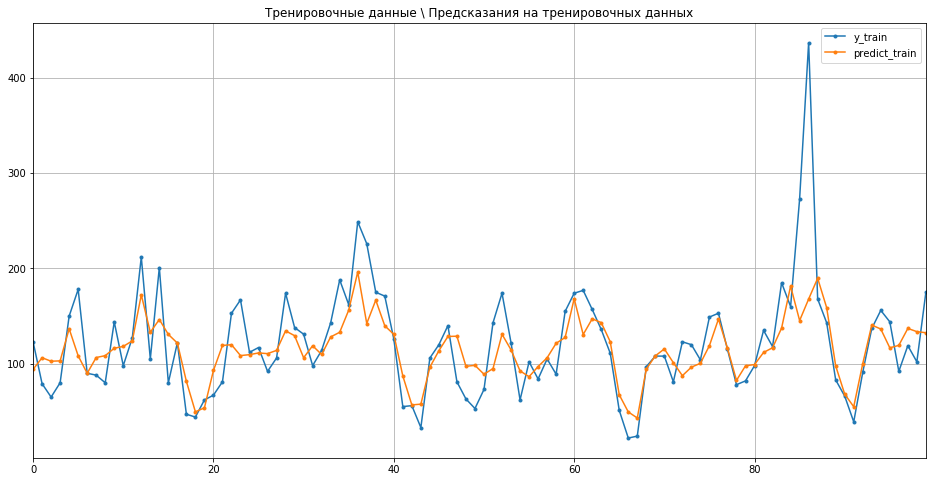

In [359]:
# Укрупнимся 100 последних точек

df_predict = pd.DataFrame({'y_train':y_train[-100:], 'predict_train':predict_train[-100:]})
df_predict.plot(figsize = (16,8), style = '.-', grid = True, \
                title = 'Тренировочные данные \ Предсказания на тренировочных данных');

In [360]:
predict_test = model.predict(X_test)

In [361]:
RMSE_test = mean_squared_error(y_test, predict_test)**.5
print('Метрика RMSE на тестовых данных данных: %.2f'%RMSE_test)

Метрика RMSE на тестовых данных данных: 43.77


На тестовых данных ошибка примерно равна стандартному отклонению дата сета (45)

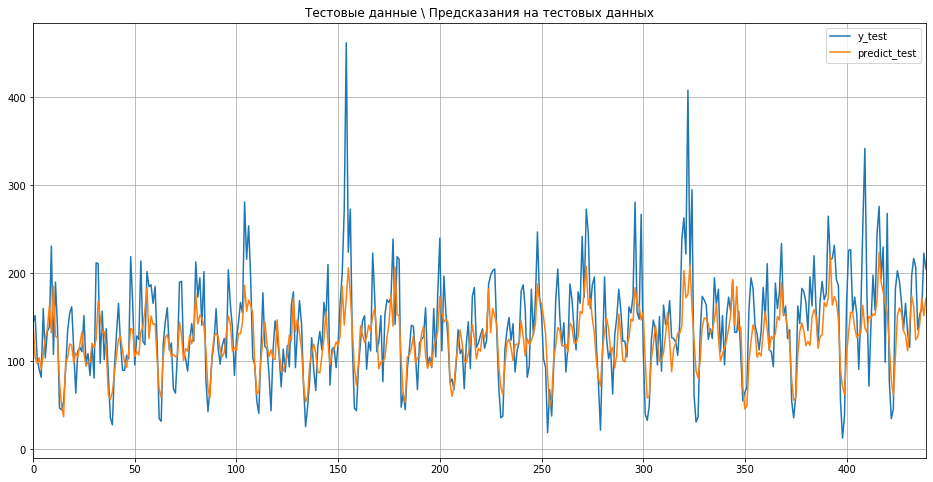

In [362]:
df_predict = pd.DataFrame({'y_test':y_test, 'predict_test':predict_test})
df_predict.plot(figsize = (16,8), style = '-', grid = True, title = 'Тестовые данные \ Предсказания на тестовых данных');

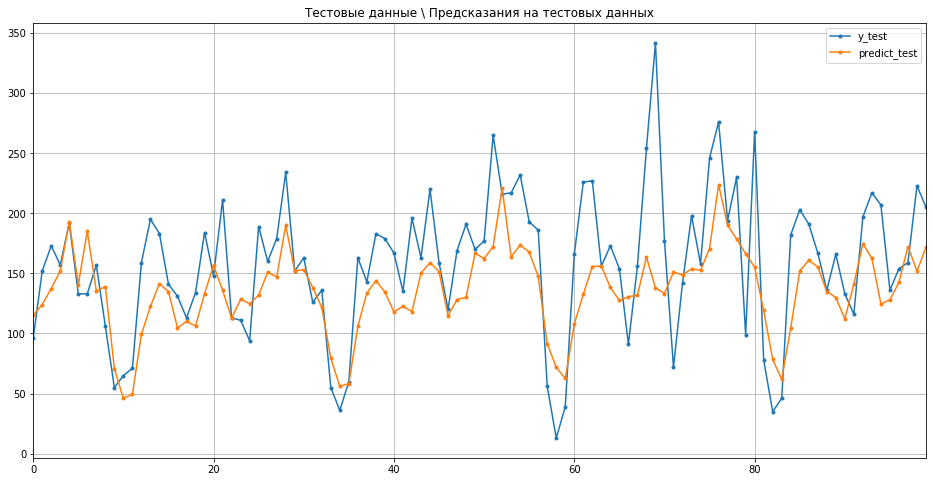

In [363]:
df_predict = pd.DataFrame({'y_test':y_test[-100:], 'predict_test':predict_test[-100:]})
df_predict.plot(figsize = (16,8), style = '.-', grid = True, title = 'Тестовые данные \ Предсказания на тестовых данных');

In [364]:
df_result = append_result('RidgeCV', 'Исходные данные', time_fit, time_predict, RMSE_train, RMSE_test)
df_result

,DataSet,Model,RMSE test,RMSE train,"Time Fit, (сек)","Time Predict, (сек)"
0,Исходные данные,RidgeCV,43.77,22.69,7.06,7.06


Очень интересно чем занималась регуляризация. Существенное вияние в худшую сторону получалось только на очень больших alpha

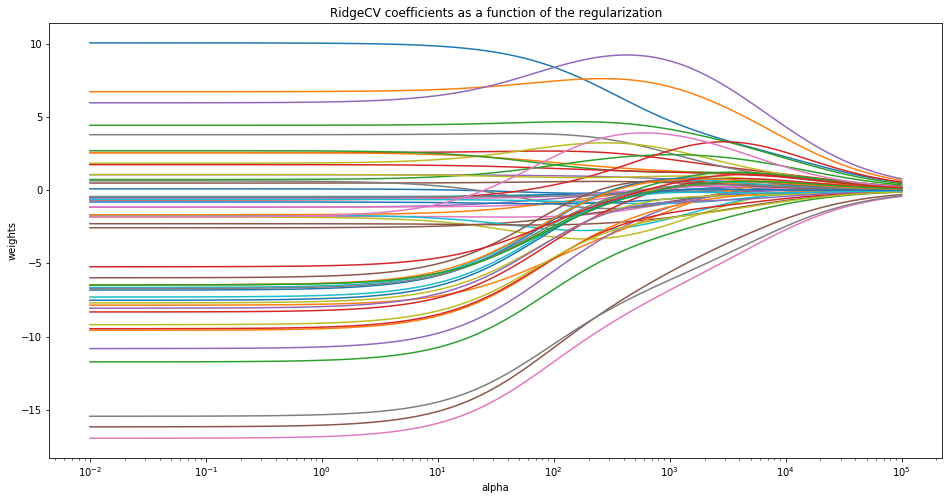

In [365]:
n_alphas = 100
alphas = np.logspace(-2, 5, n_alphas)

coefs = []
for a in alphas:
    model = RidgeCV(scoring=RMSE_scorer, cv = cv, alphas = [a], fit_intercept=True)
    model.fit(X_train, y_train)
    #coefs.append(np.log(np.abs(model.coef_)))
    coefs.append(model.coef_)

# #############################################################################
# Display results

plt.figure(figsize = (16,8))
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('RidgeCV coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

По факту RidgeCV при оптимизации метрики сносит в сторону наименьших alpha и по факту она превращается в обычную линейную регрессию.

### LGBMRegressor

Зайдем с другой стороны. Деревья. У четом того что Бустинг немного освоен, грех не воспользоваться.

In [366]:
model5 = LGBMRegressor(n_jobs = cores, random_state = state)

In [367]:
# Получим список возможных гиперпараметров модели

hyperparams = {keys: [model5.get_params()[keys]] for keys in model5.get_params()}
hyperparams

{'boosting_type': ['gbdt'],
 'class_weight': [None],
 'colsample_bytree': [1.0],
 'importance_type': ['split'],
 'learning_rate': [0.1],
 'max_depth': [-1],
 'min_child_samples': [20],
 'min_child_weight': [0.001],
 'min_split_gain': [0.0],
 'n_estimators': [100],
 'n_jobs': [-1],
 'num_leaves': [31],
 'objective': [None],
 'random_state': [12345],
 'reg_alpha': [0.0],
 'reg_lambda': [0.0],
 'silent': [True],
 'subsample': [1.0],
 'subsample_for_bin': [200000],
 'subsample_freq': [0]}

In [368]:
grid_param =\
    {
    'boosting_type': ['gbdt', 'goss'],
    'n_estimators':np.linspace(2,100, 3, dtype = 'int'),
    'max_depth':np.linspace(2,10, 3, dtype = 'int'),
    'colsample_bytree':[0.3, 0.5, 0.8, 1],
    'reg_alpha':[0.1, 0.5, 1, 10],
    'reg_lambda':[0.1, 0.5, 1, 10],
    'learning_rate':[0.05, 0.1, 0.5, 1]
    }     

grid_param


{'boosting_type': ['gbdt', 'goss'],
 'n_estimators': array([  2,  51, 100]),
 'max_depth': array([ 2,  6, 10]),
 'colsample_bytree': [0.3, 0.5, 0.8, 1],
 'reg_alpha': [0.1, 0.5, 1, 10],
 'reg_lambda': [0.1, 0.5, 1, 10],
 'learning_rate': [0.05, 0.1, 0.5, 1]}

Для начала выполним грубый поиск рандомайз серчем по параметрам отвечающим за качество модели. Параметры выбраны исходя из некого здравого смысла. Количество деревьев для данного этапа небольшое. На втором этапе подберем количество деревьев.


In [369]:
# Специальная кросвалидация для временных рядов.

cv = TimeSeriesSplit(n_splits = 5)

In [370]:
# 20 итераций случайного подбора параметром с кроссвалидацией.

search = RandomizedSearchCV(model5, grid_param, cv = cv,  n_iter =20, n_jobs = cores, \
                            scoring = RMSE_scorer, verbose=1, random_state = state) 

In [371]:
start_time = time.time()
search.fit(X_train, y_train);
time_fit = time.time() - start_time
print('Время обучения LGBMRegressor: %.3f сек.'%time_fit)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished


Время обучения LGBMRegressor: 113.374 сек.


In [372]:
# Посмотрим наилучшие параметы и скоре
best_model = search.best_estimator_
search.best_params_,  search.best_score_

({'reg_lambda': 10,
  'reg_alpha': 0.5,
  'n_estimators': 100,
  'max_depth': 6,
  'learning_rate': 0.1,
  'colsample_bytree': 0.3,
  'boosting_type': 'gbdt'},
 -25.405338248284302)

In [373]:
pd.DataFrame(search.best_estimator_.feature_importances_, df_X.columns,\
                   columns = ['Важность']).sort_values(by = 'Важность', ascending = False)

,Важность
lag_7,125
lag_2,119
lag_3,119
lag_6,116
lag_18,114
lag_1,111
lag_24,105
lag_19,102
lag_11,100
lag_5,93


Лес с фичами работает совершенно по другому. Наибольшая важность у фич только основанных на лагах.

In [374]:
start_time = time.time()
predict_train = search.best_estimator_.predict(X_train)
time_predict = time.time() - start_time
print('Время предсказания LGBMRegressor: %.3f сек.'%time_predict)

RMSE_train = mean_squared_error(y_train, predict_train)**.5
print('Метрика RMSE на тренировочных данных данных: %.2f'%RMSE_train)

Время предсказания LGBMRegressor: 0.036 сек.
Метрика RMSE на тренировочных данных данных: 16.39


На тренировчных данных ошибка 30% стандартного отклонения данных. Похоже переобучились.

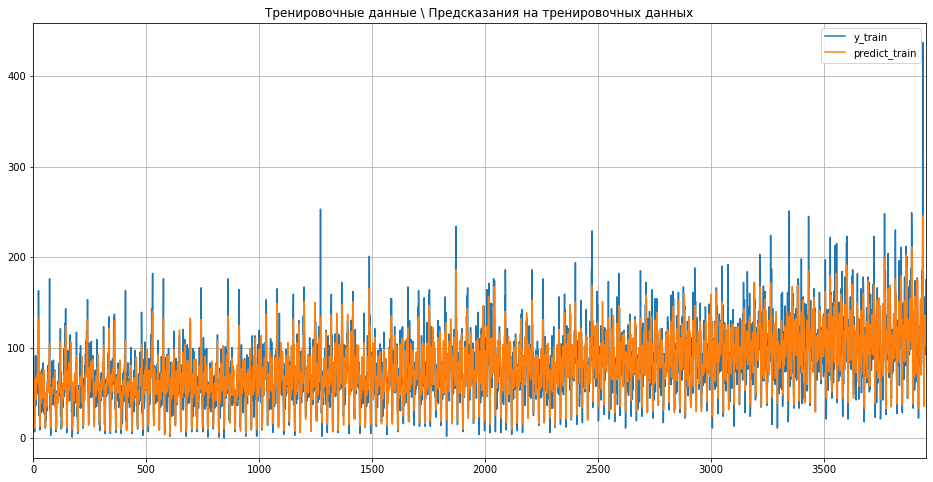

In [375]:
df_predict = pd.DataFrame({'y_train':y_train, 'predict_train':predict_train})
df_predict.plot(figsize = (16,8), grid = True, title = 'Тренировочные данные \ Предсказания на тренировочных данных');

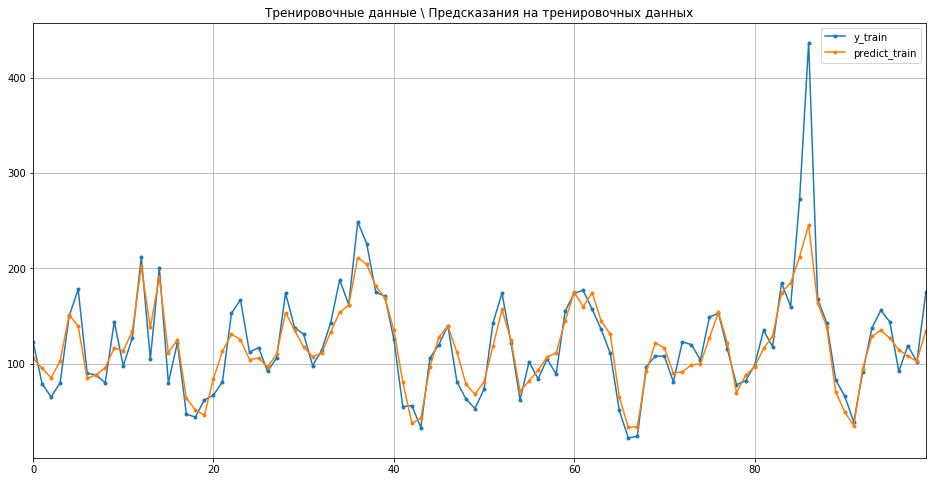

In [376]:
df_predict = pd.DataFrame({'y_train':y_train[-100:], 'predict_train':predict_train[-100:]})
df_predict.plot(figsize = (16,8), grid = True, style = '.-',\
                title = 'Тренировочные данные \ Предсказания на тренировочных данных');

Выглядит красиво.

In [377]:
predict_test = search.best_estimator_.predict(X_test)
RMSE_test = mean_squared_error(y_test, predict_test)**.5    
print('Метрика RMSE на тестовых данных данных: %.2f'%RMSE_test)


Метрика RMSE на тестовых данных данных: 43.12


Здесь ошибка почти как у линейной регрессии с регуляризацией и практически равна стандартному отклонению.

In [378]:
df_predict = pd.DataFrame({'y_test':y_test, 'predict_test':predict_test})

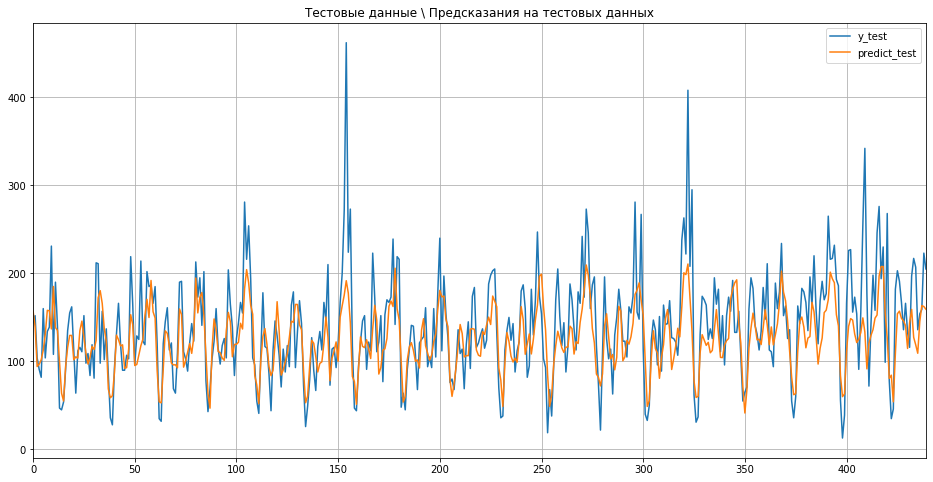

In [379]:
df_predict.plot(figsize = (16,8), grid = True, title = 'Тестовые данные \ Предсказания на тестовых данных');

In [380]:
df_predict = pd.DataFrame({'y_test':y_test[-100:], 'predict_test':predict_test[-100:]})

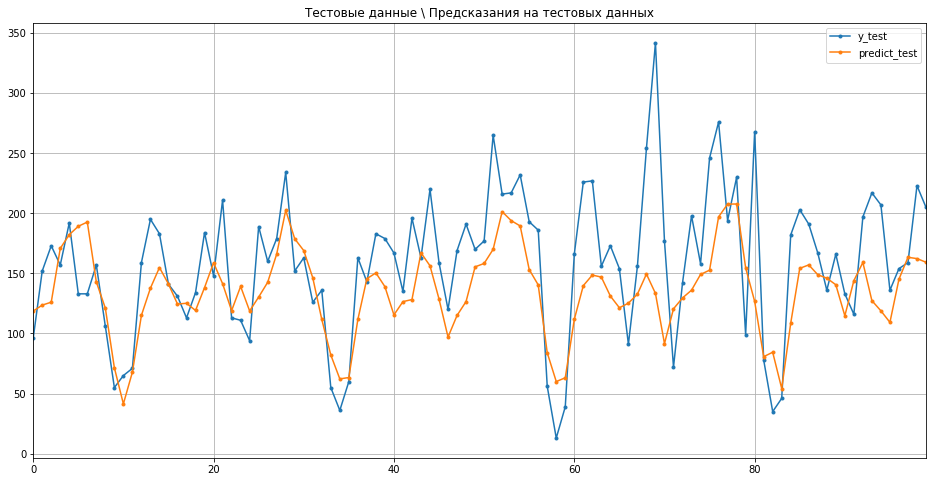

In [381]:
df_predict.plot(figsize = (16,8), style = '.-', grid = True, title = 'Тестовые данные \ Предсказания на тестовых данных');

На тестовых данных все как у людей. Совершенно нормальная ошибка.

In [382]:
df_result = append_result('LGBMRegressor', 'Исходные данные', time_fit, time_predict, RMSE_train, RMSE_test)
df_result

,DataSet,Model,RMSE test,RMSE train,"Time Fit, (сек)","Time Predict, (сек)"
0,Исходные данные,RidgeCV,43.77,22.69,7.06,7.06
1,Исходные данные,LGBMRegressor,43.12,16.39,113.37,113.37


### LGBMRegressor на дополнительно обработанном дата сете

Как известно любые деревья не очень любят тренды. Хотя тест на стационарность временного ряда показал условную стационарность, визульно тренд виден. Во вторых, исходная обработка данных предполагала OHE кодирование более пригодное для регрессионных моделей. Поэтому выполныим подготовку данных под деревья индивидуально.

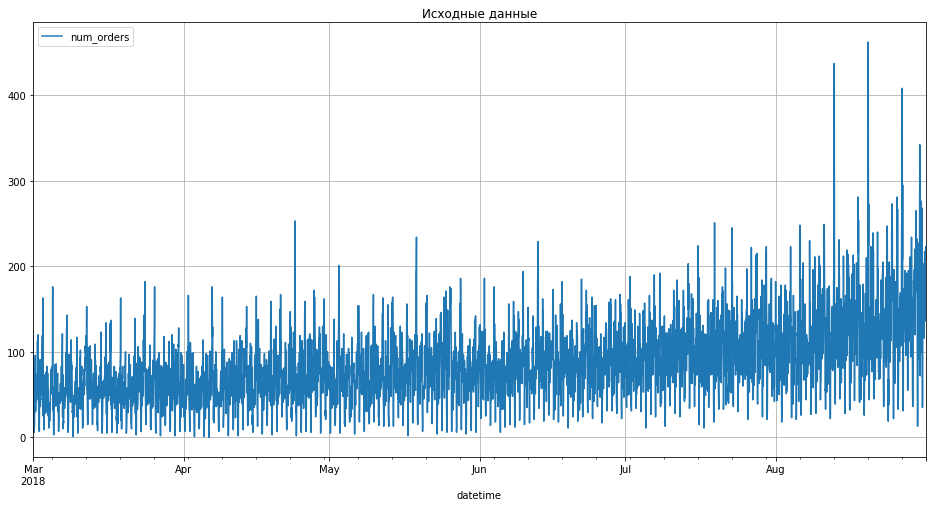

In [383]:
## Исходные данные сгруппированные до часа
df_h = df.resample('1H').sum()
df_h.plot(figsize = (16,8), grid = True, title = 'Исходные данные');

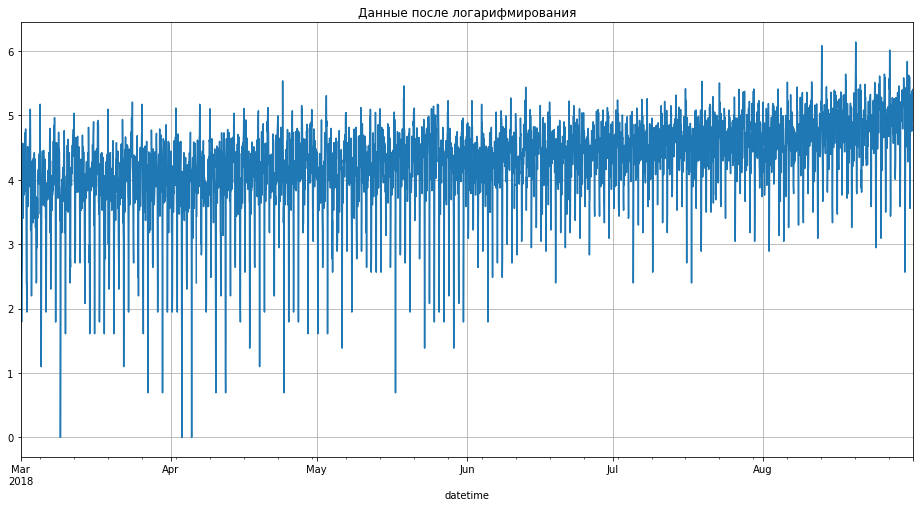

In [384]:
df_h['num_orders_log'] = df_h['num_orders'].apply(np.log)
df_h['num_orders_log'].plot(figsize = (16,8), grid = True, title = 'Данные после логарифмирования');

In [385]:
df_h['num_orders_log']= df_h['num_orders_log'].replace([np.inf, -np.inf], np.NaN)
df_h.dropna(inplace = True)
df_h = df_h.resample('1H').sum()
df_h.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 2 columns):
num_orders        4416 non-null int64
num_orders_log    4416 non-null float64
dtypes: float64(1), int64(1)
memory usage: 103.5 KB


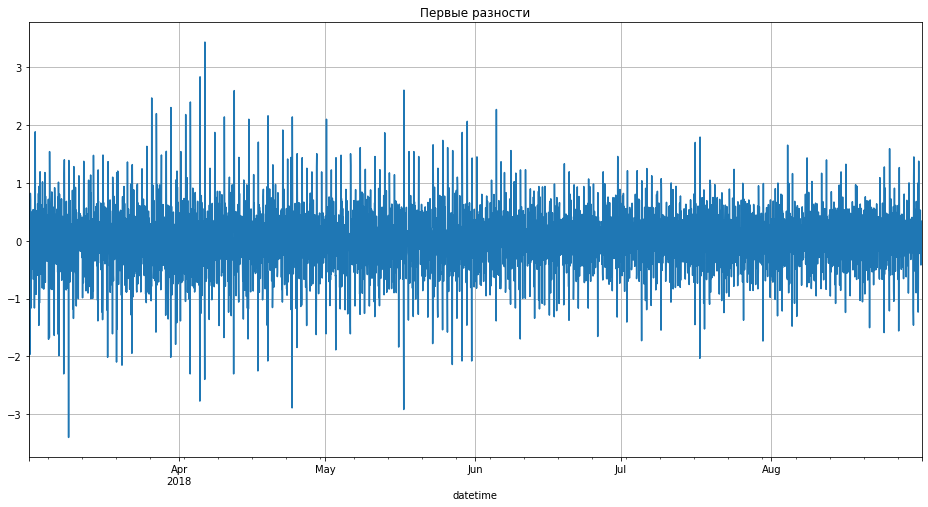

In [386]:
df_h['num_orders_log_diff'] = df_h.num_orders_log - df_h.num_orders_log.shift(1)
df_h['num_orders_log_diff']= df_h['num_orders_log_diff'].replace([np.inf, -np.inf], np.NaN)
df_h.dropna(inplace = True)
df_h = df_h.resample('1H').sum()

df_h['num_orders_log_diff'].plot(figsize = (16,8), grid = True, title = 'Первые разности');


In [387]:
df_h = df_h.drop(['num_orders', 'num_orders_log'], axis = 1)
df_h.head()


,num_orders_log_diff
datetime,
2018-03-01 01:00:00,-0.377630
2018-03-01 02:00:00,-0.179971
2018-03-01 03:00:00,-0.073025
2018-03-01 04:00:00,-0.428455
2018-03-01 05:00:00,-1.969441


In [388]:
df_h.describe()

,num_orders_log_diff
count,4415.000000
mean,0.000114
std,0.561521
min,-3.401197
25%,-0.303682
50%,0.014389
75%,0.321056
max,3.433987


Здесь стандартное отклонени таргета 0.56 тоже запомним эту цифру

In [389]:
test = adfuller(df_h['num_orders_log_diff'])

In [390]:
print ('adf: ', test[0]) 
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -16.68495841607875
p-value:  1.5053039067361632e-29
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
единичных корней нет, ряд стационарен


Вот теперь ряд стационарен так стационарен!!!

In [391]:
## Фичи для учета тренда, пока оставим, посмотрим как будет использованое в таблице важности
df_h['week_of_year'] = df_h.index.weekofyear

## Фичи для учета сезонности
df_h['dayofweek'] = df_h.index.dayofweek
df_h['hour'] = df_h.index.hour

## Лаги 24 штуки, с точки зрения охватить полные сутки
for i in range(1, 25):
        df_h["lag_{}".format(i)] = df_h.num_orders_log_diff.shift(i)
        
df_h.dropna(inplace = True)

## Условно категориальные поля оставим без дальнейшей обработки, т.к будет работать дерево
# categorical_columns = ['dayofweek', 'hour']

# Масштабирование также не нужно
# scaler = StandardScaler()

In [392]:
df_X = df_h.drop('num_orders_log_diff', axis = 1)

X = df_X.values
y = df_h['num_orders_log_diff'].values

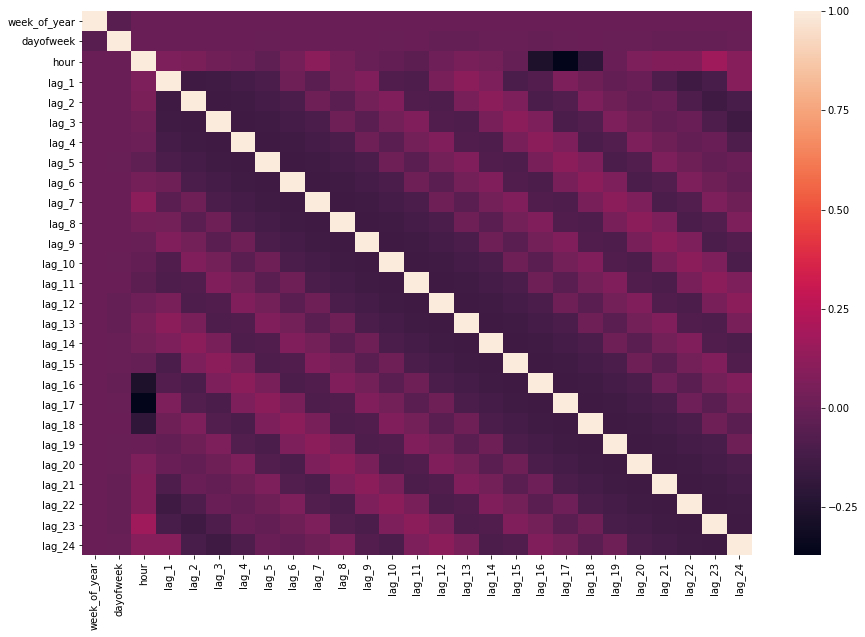

In [393]:
plt.figure(figsize = (15,10))
sns.heatmap(df_X.corr());

Корреляцией и не пахнет. 

In [394]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state = state, shuffle = False)

In [395]:
X.shape,  y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4391, 27), (4391,), (3951, 27), (440, 27), (3951,), (440,))

In [396]:
model5 = LGBMRegressor(n_jobs = cores, random_state = state)

In [397]:
# Получим список возможных гиперпараметров модели

hyperparams = {keys: [model5.get_params()[keys]] for keys in model5.get_params()}
hyperparams

{'boosting_type': ['gbdt'],
 'class_weight': [None],
 'colsample_bytree': [1.0],
 'importance_type': ['split'],
 'learning_rate': [0.1],
 'max_depth': [-1],
 'min_child_samples': [20],
 'min_child_weight': [0.001],
 'min_split_gain': [0.0],
 'n_estimators': [100],
 'n_jobs': [-1],
 'num_leaves': [31],
 'objective': [None],
 'random_state': [12345],
 'reg_alpha': [0.0],
 'reg_lambda': [0.0],
 'silent': [True],
 'subsample': [1.0],
 'subsample_for_bin': [200000],
 'subsample_freq': [0]}

In [398]:
grid_param =\
    {
    'boosting_type': ['gbdt', 'goss'],
    'n_estimators':np.linspace(2,100, 3, dtype = 'int'),
    'max_depth':np.linspace(2,10, 3, dtype = 'int'),
    'colsample_bytree':[0.3, 0.5, 0.8, 1],
    'reg_alpha':[0.1, 0.5, 1, 10],
    'reg_lambda':[0.1, 0.5, 1, 10],
    'learning_rate':[0.05, 0.1, 0.5, 1]
    }     

grid_param


{'boosting_type': ['gbdt', 'goss'],
 'n_estimators': array([  2,  51, 100]),
 'max_depth': array([ 2,  6, 10]),
 'colsample_bytree': [0.3, 0.5, 0.8, 1],
 'reg_alpha': [0.1, 0.5, 1, 10],
 'reg_lambda': [0.1, 0.5, 1, 10],
 'learning_rate': [0.05, 0.1, 0.5, 1]}

Для начала выполним грубый поиск рандомайз серчем по параметрам отвечающим за качество модели. Параметры выбраны исходя из некого здравого смысла. Количество деревьев для данного этапа небольшое. На втором этапе подберем количество деревьев.


In [399]:
cv = TimeSeriesSplit(n_splits = 5)

In [400]:
# 20 итераций случайного подбора параметром с кроссвалидацией.

search = RandomizedSearchCV(model5, grid_param, cv = cv,  n_iter =20, n_jobs = cores, \
                            scoring = RMSE_scorer, verbose=1, random_state = state) 

In [401]:
start_time = time.time()
search.fit(X_train, y_train);
time_fit = time.time() - start_time
print('Время обучения LGBMRegressor: %.3f сек.'%time_fit)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   38.9s finished


Время обучения LGBMRegressor: 40.247 сек.


In [402]:
# Посмотрим наилучшие параметы и скоре
best_model = search.best_estimator_
search.best_params_,  search.best_score_

({'reg_lambda': 10,
  'reg_alpha': 0.5,
  'n_estimators': 100,
  'max_depth': 6,
  'learning_rate': 0.1,
  'colsample_bytree': 0.3,
  'boosting_type': 'gbdt'},
 -0.40618562133766806)

In [403]:
pd.DataFrame(search.best_estimator_.feature_importances_, df_X.columns,\
                   columns = ['Важность']).sort_values(by = 'Важность', ascending = False)

,Важность
hour,207
lag_1,178
lag_24,137
lag_6,137
lag_2,134
lag_5,134
lag_17,124
lag_19,118
lag_10,115
lag_11,115


В топ вылез час заказа. Как мы видели на сезонном графике, внутри дня очень стабильные колебания. Поймали.

In [404]:
start_time = time.time()
predict_train = search.best_estimator_.predict(X_train)
time_predict = time.time() - start_time
print('Время предсказания LGBMRegressor: %.3f сек.'%time_predict)

RMSE_train = mean_squared_error(y_train, predict_train)**.5
print('Метрика RMSE на тренировочных данных данных: %.2f'%RMSE_train)

Время предсказания LGBMRegressor: 0.018 сек.
Метрика RMSE на тренировочных данных данных: 0.26


На тренировочных данных ошибка почти половина стандартного отклонения. Хуже чем на первом дата сете.

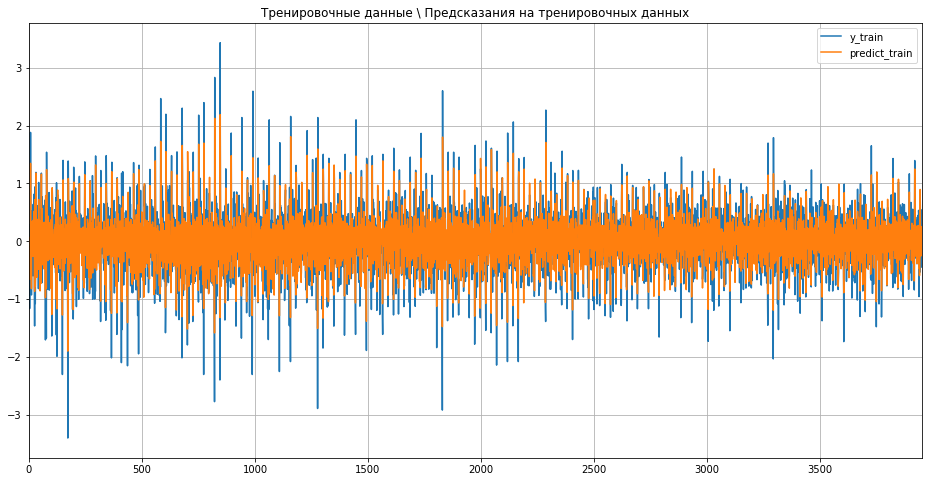

In [405]:
df_predict = pd.DataFrame({'y_train':y_train, 'predict_train':predict_train})
df_predict.plot(figsize = (16,8), grid = True, title = 'Тренировочные данные \ Предсказания на тренировочных данных');

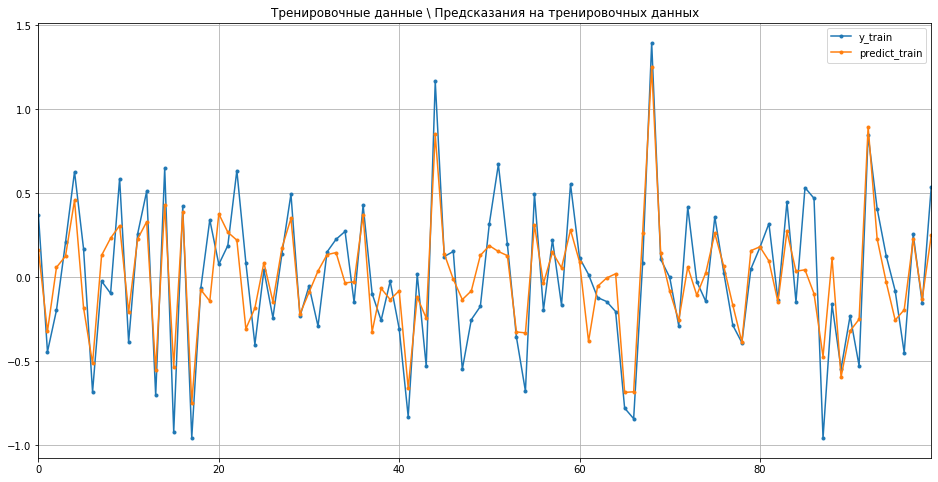

In [406]:
df_predict = pd.DataFrame({'y_train':y_train[-100:], 'predict_train':predict_train[-100:]})
df_predict.plot(figsize = (16,8), grid = True, style = '.-', \
                title = 'Тренировочные данные \ Предсказания на тренировочных данных');

In [407]:
predict_test = search.best_estimator_.predict(X_test)
RMSE_test = mean_squared_error(y_test, predict_test)**.5    
print('Метрика RMSE на тестовых данных данных: %.2f'%RMSE_test)


Метрика RMSE на тестовых данных данных: 0.33


А вот на тестовых данных ошибка 0.33/0.56 в стандартных отклонениях, всетаки значимо лучше чем на первом (не корректированном) дата сете. Сообственно подтвердили чего хотели, деревья не любят трендов!

In [408]:
df_predict = pd.DataFrame({'y_test':y_test, 'predict_test':predict_test})

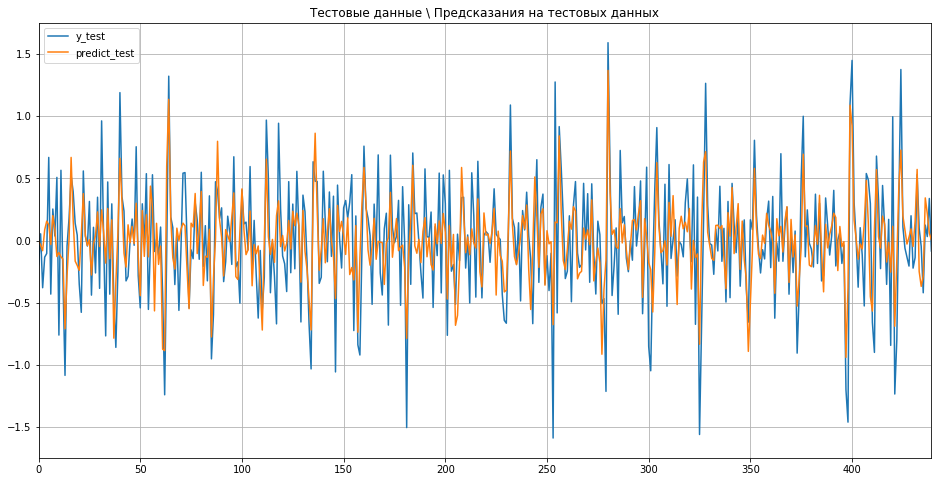

In [409]:
df_predict.plot(figsize = (16,8), grid = True, title = 'Тестовые данные \ Предсказания на тестовых данных');

In [410]:
df_predict = pd.DataFrame({'y_test':y_test[-100:], 'predict_test':predict_test[-100:]})

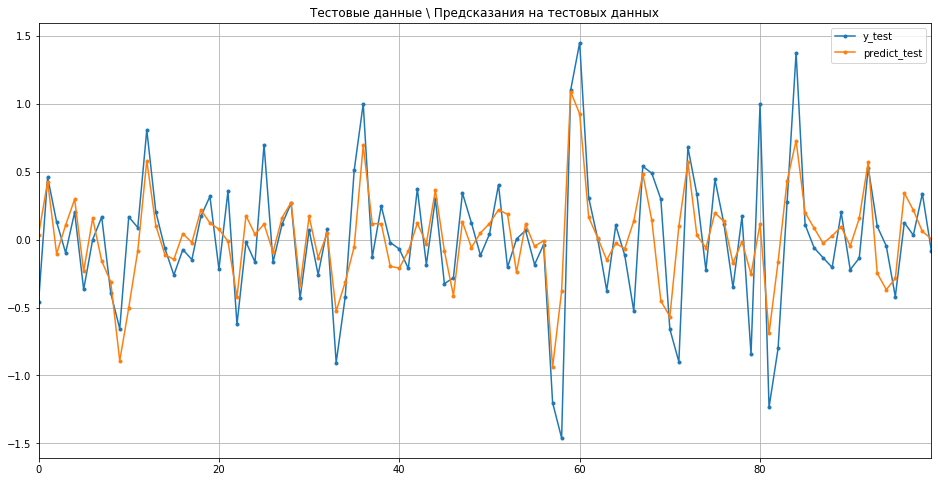

In [411]:
df_predict.plot(figsize = (16,8), grid = True, style ='.-', title = 'Тестовые данные \ Предсказания на тестовых данных');

In [412]:
df_result = append_result('LGBMRegressor', 'Данные log + diff', time_fit, time_predict, RMSE_train, RMSE_test)
df_result

,DataSet,Model,RMSE test,RMSE train,"Time Fit, (сек)","Time Predict, (сек)"
0,Исходные данные,RidgeCV,43.77,22.69,7.06,7.06
1,Исходные данные,LGBMRegressor,43.12,16.39,113.37,113.37
2,Данные log + diff,LGBMRegressor,0.33,0.26,40.25,40.25


Собственная это и есть итоговая таблица работы моделей. Конечно нужно бы добавить долю RMSE в стандартном отклонении данных о которой писал

## Выводы

Временные ряды огонь. Собственно ради этого раздела я вообще начал интересовать машинным обучением. Сейчас приоритеты уже не столько выражены, но всеравно.
- Получен очень важный навык, как вобще работать с временными рядами. Начало положено.
- Проверен простой алгоритм - нарезаем фич - обрабатываем обычными моделями, результат вполне приличный
- В перспективе освоить ARIMA/SARIMA модели, более подходящие для временных рядов, но крайне ресурсоемкие
- Во текущей задаче данные проанализированы,выделены значимые составляющие это восходящий тренд, колебания внутри недели и колебания внутри дня
- Под понятные зависимости нарезаны фичи, номер недели под тренд, номер дня под недельные колебания, номер часа под дневные колебания
- Сначала моделирование проведено только на этих фичах. Регрессия получилась очень простой, по сути улучшенное среднее, количество фич и соответсвенно количество коэффициентов мало, предсказать сложные зависимости не получается.
- Доллил фич - 24 лаги, начиная с 1 часа, так как угадывать просят следующий час, ну и 24 часа, чтобы масимально описать дневные колебания. Ситуация радикально изменилась, регрессия может повторять очень сложные колебания.
- На самом деле количество фич пробовал увеличивать до 50, качество модели растет, но не существенно.
- Дополнительно применил OHE ко номеру дня и номеру часа,т.к. всетаки Четверг не больше чем Понедельник. Результат заметно улучшился.
- В качестве альтернативной модели взял только что изученный Бустинг над деревьями, а именно LGBMRegressor. Результат на трейне ошеломляющий, понятно переобучились, на тесте - типа как у регресси. Точнось работы примерно такая же около одного стандартного отклонения относительно среднего количества заказов.
- Все таки хотелось красоты деревьев, а им как известно сильно мешают тренды. Дообработал дата сет, логарифм плюс первые разности. Стационарность стала просто до минус 39 степени.
- Повторил работу бустинга над деревьями. И результат уже слегка другой ошибка 60% от стандартного отклонения. Рост прироста налицо.
- Минимальное RMSE  на другом  количестве фич удалось получить около 39
- Работа выполнена, удовольствие получено.